In [1]:
%load_ext autoreload
%autoreload 2
import bert
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import spike_queries
from termcolor import colored
import random
from collections import Counter, defaultdict
from viterbi_trellis import ViterbiTrellis

In [2]:

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [3]:
def load_results(fname):
    
    with open(fname, "r", encoding = "utf-8") as f:
        sents = f.readlines()
    
    sents = [s.strip().replace("<s1>","").replace("<s2>","").replace("<e1>", "").replace("<e2>","").replace("h:","").
             split("\t")[-1] for s in sents]
    original, results = sents[0], sents[1:]
    return original, results


def get_spike_results_arguments_representations(model, spike_results, layers):
    
    sents = spike_results["sentence_text"].tolist()
    arg1_idx_start = spike_results["arg1_first_index"].to_numpy().astype(int)
    arg2_idx_start = spike_results["arg2_first_index"].to_numpy().astype(int)
    arg1_idx_end = spike_results["arg1_last_index"].to_numpy().astype(int)
    arg2_idx_end = spike_results["arg2_last_index"].to_numpy().astype(int)
    
    arg1_rep = []
    arg2_rep = []
    
    for s, arg1_start, arg2_start, arg1_end, arg2_end in zip(sents, arg1_idx_start, arg2_idx_start, arg1_idx_end, arg2_idx_end):
        #idx_to_mask = [arg1_start, arg2_start, arg1_end, arg2_end]
        H, _, _, orig2tok = model.encode(s, layers = layers)

        h1, h2 = H[orig2tok[arg1_start]:orig2tok[arg1_end] + 1], H[orig2tok[arg2_start]:orig2tok[arg2_end] + 1]
        
        h1 = np.mean(h1, axis = 0)
        h2 = np.mean(h2, axis = 0)
        
        arg1_rep.append(h1)
        arg2_rep.append(h2)
        
    arg1_mean = np.mean(arg1_rep, axis = 0)
    arg2_mean = np.mean(arg2_rep, axis = 0)
        
    return arg1_mean, arg2_mean
    

def print_sentence_nicely(sentence: str, ind1, ind2):
    
    arg1_sign = "**"
    arg2_sign = "++"
    arg1_color, arg2_color = "red", "blue"
    
    if not ind2 > ind1: 
        ind1, ind2 = ind2, ind1
        arg1_sign, arg2_sign = arg2_sign, arg1_sign
        arg1_color, arg2_color = arg2_color, arg1_color
        
    splitted = sentence.split(" ")
    before_arg1 = " ".join(splitted[:ind1])
    arg1 = splitted[ind1]
    arg2 = splitted[ind2]
    between = " ".join(splitted[ind1 + 1: ind2])
    suffix = " ".join(splitted[ind2+1:])
    
    return before_arg1 +  " " + arg1_sign + colored(arg1, arg1_color) + arg1_sign + " " + between + " " + arg2_sign + colored(arg2, arg2_color) + arg2_sign + " " + suffix



def main(filename, layers = [-1], num_results_to_print = 75):
    
    
    query, results1 = load_results(filename)
    spike_results = spike_queries.perform_query(query, dataset_name = "covid19", num_results = 100, query_type = "syntactic")
    spike_results = spike_results[spike_results['sentence_text'].notnull()]
    arg1_rep, arg2_rep = get_spike_results_arguments_representations(model, spike_results, layers)
    
    #print(color.BOLD + "QUERY" + color.END + ":\n{}".format(query))
    
    first, first_ind1, first_ind2 = spike_results["sentence_text"].tolist()[-1], int(spike_results["arg1_first_index"].tolist()[-1]), int(spike_results["arg2_first_index"].tolist()[-1])
    #print(color.BOLD + "\nFIRST SPIKE RESULT" + color.END + ":\n{}".format(print_sentence_nicely(first, first_ind1, first_ind2)))
    #print(color.BOLD + "\nAUGMENTATION RESULTS:\n" + color.END)
    
    representations = []
    mappings_to_orig = []
    mappings_to_tok = []
    tokenized_txts = []
    orig_sents = []
    
    for i,s in enumerate(results1):
        H, tokenized_text, tok_to_orig_map, orig2tok = model.encode(s, layers = layers)
        orig_sents.append(s)
        representations.append(H)
        mappings_to_orig.append(tok_to_orig_map)
        mappings_to_tok.append(orig2tok) 
        tokenized_txts.append(tokenized_text)
        
        if i > num_results_to_print: break
    
    return query, (arg1_rep, arg2_rep), (representations, mappings_to_orig, mappings_to_tok, tokenized_txts, orig_sents)


def get_between_tokens_similarity(padded_representations):
    
    num_sents, seq_len, bert_dim = padded_representations.shape
    padded_representations = padded_representations.reshape((num_sents*seq_len, bert_dim))
    sims = cosine_similarity(padded_representations, padded_representations)
    sims = sims.reshape((num_sents, seq_len, num_sents, seq_len))
    
    return sims

def get_between_token_similarity_prev_sentence(padded_representations):
    
    num_sents, seq_len, bert_dim = padded_representations.shape
    padded_representations = padded_representations.reshape((num_sents*seq_len, bert_dim))    
    padded_representations /= np.linalg.norm(padded_representations, keepdims = True, axis=1)
    padded_representations = padded_representations.reshape((num_sents, seq_len, bert_dim))
    tuples = list(zip(padded_representations, padded_representations[1:]))
    sims = np.array([tup[0].dot(tup[1].T) for tup in tuples])
    sims = sims.reshape(((num_sents-1)*seq_len, seq_len))
    return sims

def get_similarity_to_arguments(padded_representations, arg1, arg2):
    num_sents, seq_len, bert_dim = padded_representations.shape
    padded_representations = padded_representations.reshape((num_sents*seq_len, bert_dim))
    #print(padded_representations.shape)
    sims = cosine_similarity([arg1_rep, arg2_rep], padded_representations)
    sims = sims.reshape((2, num_sents, seq_len))
    return sims

In [4]:
model = bert.BertEncoder("cuda", "scibert")

loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/allenai/scibert_scivocab_uncased/config.json from cache at /home/shauli/.cache/torch/transformers/199e28e62d2210c23d63625bd9eecc20cf72a156b29e2a540d4933af4f50bda1.4b6b9f5d813f7395e7ea533039e02deb1723d8fd9d8ba655391a01a69ad6223d
Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 31090
}

loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/allenai/scibert_scivocab_uncased/config.json from cache at /home/shauli/.cache/torch/transformers/199e28e62d2210c23d63625bd9eecc20cf72a156b29e2a540d4933af4f50bda1.4b6b9f5d8

In [5]:

def get_probable_alignments(sims_args, mappings_to_orig):
    argument2sent2alignments = dict()
    
    """
    :param sims_args: similarity to arguments per query, shape: [2,num_sents,padded_sent_len]
    :return: 
    """
    
    for arg in range(2):
        sent2alignments = dict()
        for sent_ind in range(sims_args.shape[1]):
            sorted_sims_idx = np.argsort(-sims_args[arg][sent_ind])
            sorted_sims_vals = sims_args[arg][sent_ind][sorted_sims_idx]            
            sorted_sims_idx_mapped = [mappings_to_orig[sent_ind][j] if j in mappings_to_orig[sent_ind] else -1 for j in sorted_sims_idx]
            sent2alignments[sent_ind] = list(zip(sorted_sims_idx_mapped, sorted_sims_vals))
        
        argument2sent2alignments[arg] = sent2alignments

    return argument2sent2alignments

In [6]:
np.nan

nan

In [7]:
query2arg2preds = defaultdict(dict)

for q in [1,2,4,5,6,7,8,9]:
    
    # collect representations of arguments & results
    
    fname = "results{}.txt".format(q)
    query, (arg1_rep, arg2_rep), (representations, mappings_to_orig, mappings_to_tok, tokenized_txts, orig_sents)  = main(fname, layers = [-1])
    for i in range(len(representations)): # zero cls, ., sep
        representations[i][0][:] = np.random.rand()
        representations[i][-1][:] = np.random.rand()
        representations[i][-2][:] = np.random.rand()

    
    pad_width = max([len(s) for s in representations])
    padded_representations = np.array([np.concatenate([r, -np.ones((pad_width-len(r), 768))]) for r in representations])

    num_sents, seq_len, bert_dim = padded_representations.shape
    num_tokens = num_sents * seq_len
    sims_args = get_similarity_to_arguments(padded_representations, arg1_rep, arg2_rep) #(2, num_sents, padded_sent_len)
    
    arguments2sent2alignments = get_probable_alignments(sims_args, mappings_to_orig)
    for arg in range(2):
        dicts = [{"sent": orig_sents[i], "pred_idx": list(zip(*arguments2sent2alignments[arg][i]))[0], 
                "preds_sims":  list(zip(*arguments2sent2alignments[arg][i]))[1]} for i in range(num_sents)]
        
        
        query2arg2preds[q][arg] = dicts

# Evalation

In [8]:
def load_gold():
    query2sent2gold = defaultdict(dict)
    
    for query in [1,2,4,5,6,7,8,9]:
        
        fname = "results{}.txt".format(query)
        
        with open(fname, "r", encoding = "utf-8") as f:
            sents = f.readlines()
    
        original, results = sents[0], sents[1:]
        
        sent2gold = defaultdict(dict)
        query_stop = False
        
        for i,line in enumerate(results):
            
            if line.count("<s1>") != line.count("<e1>"):
                print(line)
                print("<<<<<ERROR>>>>>", query, i)
            if query_stop: break
                
            sent_data_relevant = []
            sent_data_arg1 = []
            sent_data_arg2 = []
            
            _, sent = line.strip().split("\t")
            tokens = sent.split(" ")
            
            found_start_arg1 = False
            found_start_arg2 = False
            start_arg1 = None
            start_arg2 = None
            
            for j,tok in enumerate(tokens):
                
                if "h:" in tok:
                    sent_data_relevant.append(j)
                
                if "<s1>" in tok:
                    found_start_arg1 = True
                    start_arg1 = j
                elif "<s2>" in tok:
                    found_start_arg2 = True
                    start_arg2 = j
                
                if found_start_arg1 and "<e1>" in tok:
                    
                    sent_data_arg1.append((start_arg1, j))
                    
                    found_start_arg1 = False
                    start_arg1 = None
                    
                if found_start_arg2 and "<e2>" in tok:
                    
                    sent_data_arg2.append((start_arg2, j))
                    
                    found_start_arg2 = False
                    start_arg2 = None  
            
            sent2gold[i] = {"arg1": sent_data_arg1, "arg2": sent_data_arg2, "relevant": sent_data_relevant}
                
            if "<s1>" not in sent: 
                query_stop = True
        
        query2sent2gold[query] = sent2gold
    return query2sent2gold
        

In [20]:
query2sent2gold = load_gold()
good, bad = 0., 0.
good2, bad2 =  0., 0.
preds = []

def is_correct(ind, start_and_end, relevant):
    
    is_in_phrase = False
    is_relevant = False
    
    for (start, end) in start_and_end:
        
        if ind >= start and ind <= end:
            
            is_in_phrase = True
            if ind in relevant:
                is_relevant = True
    
    return is_in_phrase, is_relevant
        
        
def print_nicely(sent, arg1_borders, arg2_borders):
    
    
    def is_start(k, borders):
        return len([(s,e) for (s,e) in borders if s == k]) != 0
    def is_end(k, borders):
        return len([(s,e) for (s,e) in borders if e == k]) != 0
    
    sent_lst = sent.split(" ")
    sent_new = []
    for i,w in enumerate(sent_lst):
        
        if is_start(i,arg1_borders) or is_start(i,arg2_borders):
            
            type_arg = color.BLUE + "ARG1" if is_start(i,arg1_borders) else color.BLUE + "ARG2"
            sent_new.append(color.BOLD + "[" + type_arg)
            
        sent_new.append(w)

        if is_end(i,arg1_borders) or is_end(i,arg2_borders):
            
            #type_arg = color.BLUE + "ARG1" if is_end(i,arg1_borders) else "ARG2" + color.END
            sent_new.append("]" + color.END)
            
    return " ".join(sent_new)
    

for query in query2arg2preds.keys():
    
    fname = "results{}.txt".format(query)
    
    for sent_ind in range(len(query2arg2preds[query][0])):
        
        if sent_ind >= len(query2sent2gold[query].keys()): break # only look at sentences we have annotation for
        
        for arg in range(2):
            #if arg == 0: print(query2arg2preds[query][arg][sent_ind]["sent"])
            d = query2arg2preds[query][arg][sent_ind]
            mask_relevant =  np.array(d["pred_idx"]) != -1
            idx_relevant, sims_relevant = np.array(d["pred_idx"])[mask_relevant], np.array(d["preds_sims"])[mask_relevant]
            word_pred = [d["sent"].split(" ")[j] for j in idx_relevant]
            
            arg_key = "arg1" if arg == 0 else "arg2"

            if query2sent2gold[query][sent_ind][arg_key] == []: continue
             
            in_phrae_and_relevant = [is_correct(idx_relevant[k], query2sent2gold[query][sent_ind][arg_key], query2sent2gold[query][sent_ind]["relevant"]) for k in range(len(idx_relevant))]
            in_phrase, relevant = list(zip(*in_phrae_and_relevant))
            preds_annotated = []
            
            for pos, (k,w) in enumerate(zip(idx_relevant, word_pred)):
                
                #if "Individuals with diabetes" in d["sent"]:
                #    print(w,k, in_phrase[pos], relevant[pos])
            
                w_anno = color.RED + w + color.END 
                if in_phrase[pos] and relevant[pos]:

                    w_anno = color.GREEN + "[c]"+w + color.END
                elif in_phrase[pos] and not relevant[pos]:
                    w_anno = color.BLUE + "[p]" + w + color.END
                    
                
                preds_annotated.append(w_anno)         
                           
            #print(query, sent_ind)
            if arg == 0: 
                print("RESULT:", print_nicely(d["sent"], query2sent2gold[query][sent_ind]["arg1"], query2sent2gold[query][sent_ind]["arg2"]))

            print("ARG{} PREDS:".format(arg+1), ", ".join(preds_annotated[:10]))
            preds.append((word_pred, in_phrase, relevant))
                             
            if in_phrase[0]:
                good2 += 1
            else:
                bad2 += 1
                
            for (start,end) in query2sent2gold[query][sent_ind][arg_key]:
                if idx_relevant[0] >=  start and idx_relevant[0] <= end:
                     good += 1
                     break
            else:
                    bad += 1
                    """ 
                    print("query:", query)
                    print("sent_ind:", sent_ind)
                    print(d["sent"])
                    print("preds:", word_pred[:5])
                    print("argument:", arg_key)
                    print("gold:", query2sent2gold[query][sent_ind][arg_key])
                    print("pred:", idx_relevant[:5])
                    print("======================")
                    """
        
        print("============================")

RESULT: [ARG1 Hepatotropic virus ] , like [ARG1 MHV-3 infection ] in mice , can induce [ARG2 exaggerated inflammation in the liver ] and cause life-threatening viral FH .
ARG1 PREDS: [p]virus, viral, [c]infection, can, mice, inflammation, cause, [c]Hepatotropic, induce, liver
ARG2 PREDS: [c]inflammation, viral, can, [p]liver, virus, mice, induce, life-threatening, cause, infection
RESULT: In humans , [ARG1 CHIKV infections ] cause a [ARG2 debilitating disease with acute febrile illness and long-term polyarthralgia ] .
ARG1 PREDS: [c]infections, [c]CHIKV, disease, humans, In, acute, illness, a, with, ,
ARG2 PREDS: [c]disease, [c]illness, [c]acute, a, [c]polyarthralgia, [p]with, In, infections, humans, [p]and
RESULT: [ARG1 MERS-CoV ] induces [ARG2 acute pneumonia similar to that caused by SARS-CoV, ] and is sometimes accompanied with [ARG2 renal failure ] ( Danielsson and Catchpole , 2012 ; Zaki et al. , 2012 ) .
ARG1 PREDS: [c]MERS-CoV, acute, by, pneumonia, induces, is, (, by, and, by


In [36]:
rank_pred_in_phrase = [in_p.index(True) for (words,in_p,is_correct) in preds]
rank_pred_is_correct = [is_correct.index(True) if True in is_correct else 20 for (words,in_p,is_correct) in preds]

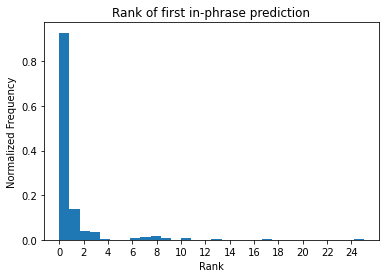

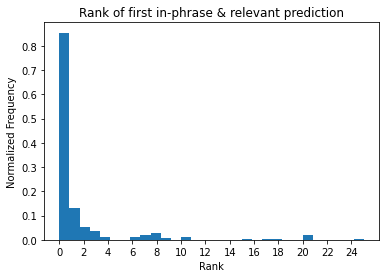

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(rank_pred_in_phrase, density=True, bins=30)
plt.title("Rank of first in-phrase prediction")
plt.xlabel("Rank")
plt.ylabel("Normalized Frequency")
plt.xticks(range(0,25,2))
plt.show()


plt.hist(rank_pred_is_correct, density=True, bins=30)
plt.title("Rank of first in-phrase & relevant prediction")
plt.xlabel("Rank")
plt.ylabel("Normalized Frequency")
plt.xticks(range(0,25,2))
plt.show()